In [16]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [17]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [18]:
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0
...,...,...,...,...,...,...,...,...,...
16995,-124.3,40.6,52.0,2217.0,394.0,907.0,369.0,2.4,111400.0
16996,-124.3,40.7,36.0,2349.0,528.0,1194.0,465.0,2.5,79000.0
16997,-124.3,41.8,17.0,2677.0,531.0,1244.0,456.0,3.0,103600.0
16998,-124.3,41.8,19.0,2672.0,552.0,1298.0,478.0,2.0,85800.0


In [19]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

In [20]:
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
8535,-118.5,34.2,36.0,1254.0,229.0,629.0,245.0,5.0,236100.0
3452,-117.9,33.7,34.0,1759.0,353.0,2083.0,330.0,3.2,160600.0
10724,-120.6,35.1,16.0,2680.0,704.0,975.0,619.0,1.8,55000.0
10943,-120.9,37.6,32.0,4579.0,914.0,2742.0,856.0,2.7,86200.0
6013,-118.2,34.1,50.0,3657.0,708.0,1725.0,644.0,5.5,258100.0
...,...,...,...,...,...,...,...,...,...
9080,-119.0,35.4,31.0,1498.0,359.0,1168.0,340.0,1.2,49300.0
10139,-119.8,36.8,35.0,1789.0,357.0,933.0,357.0,2.5,66200.0
9678,-119.5,36.5,46.0,55.0,11.0,26.0,5.0,4.1,67500.0
3188,-117.8,33.6,11.0,6840.0,1689.0,6083.0,1629.0,2.4,198300.0


In [21]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]
    ]
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"]
    )
    return processed_features

In [22]:
preprocess_features(california_housing_dataframe)

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
8535,34.2,-118.5,36.0,1254.0,229.0,629.0,245.0,5.0,2.0
3452,33.7,-117.9,34.0,1759.0,353.0,2083.0,330.0,3.2,0.8
10724,35.1,-120.6,16.0,2680.0,704.0,975.0,619.0,1.8,2.7
10943,37.6,-120.9,32.0,4579.0,914.0,2742.0,856.0,2.7,1.7
6013,34.1,-118.2,50.0,3657.0,708.0,1725.0,644.0,5.5,2.1
...,...,...,...,...,...,...,...,...,...
9080,35.4,-119.0,31.0,1498.0,359.0,1168.0,340.0,1.2,1.3
10139,36.8,-119.8,35.0,1789.0,357.0,933.0,357.0,2.5,1.9
9678,36.5,-119.5,46.0,55.0,11.0,26.0,5.0,4.1,2.1
3188,33.6,-117.8,11.0,6840.0,1689.0,6083.0,1629.0,2.4,1.1


In [26]:
def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value"] = (
        california_housing_dataframe["median_house_value"] / 1000.0
    )
    return output_targets

In [27]:
preprocess_targets(california_housing_dataframe)

,median_house_value
8535,236.1
3452,160.6
10724,55.0
10943,86.2
6013,258.1
...,...
9080,49.3
10139,66.2
9678,67.5
3188,198.3


In [28]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))

In [29]:
training_examples

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
8535,34.2,-118.5,36.0,1254.0,229.0,629.0,245.0,5.0,2.0
3452,33.7,-117.9,34.0,1759.0,353.0,2083.0,330.0,3.2,0.8
10724,35.1,-120.6,16.0,2680.0,704.0,975.0,619.0,1.8,2.7
10943,37.6,-120.9,32.0,4579.0,914.0,2742.0,856.0,2.7,1.7
6013,34.1,-118.2,50.0,3657.0,708.0,1725.0,644.0,5.5,2.1
...,...,...,...,...,...,...,...,...,...
15072,37.8,-122.2,52.0,2156.0,458.0,872.0,445.0,3.3,2.5
11144,39.2,-121.0,17.0,2277.0,459.0,1149.0,476.0,3.2,2.0
6853,34.0,-118.3,39.0,2802.0,618.0,1524.0,529.0,2.7,1.8
13582,37.2,-122.0,22.0,2781.0,523.0,1291.0,516.0,4.6,2.2


In [30]:
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2640.7,539.7,1426.7,501.5,3.9,2.0
std,2.1,2.0,12.6,2162.1,418.6,1123.1,382.9,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1464.0,298.0,791.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2129.0,434.0,1163.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3144.2,652.0,1717.2,606.0,4.7,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,55.2


In [31]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,207.7
std,116.4
min,15.0
25%,119.6
50%,180.4
75%,265.6
max,500.0


In [32]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,207.7
std,116.4
min,15.0
25%,119.6
50%,180.4
75%,265.6
max,500.0


In [33]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))

In [35]:
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2650.8,538.7,1436.5,500.5,3.9,2.0
std,2.1,2.0,12.5,2222.3,428.4,1205.3,388.3,1.9,1.0
min,32.5,-124.2,1.0,12.0,3.0,13.0,4.0,0.5,0.0
25%,33.9,-121.8,18.0,1457.0,294.0,785.8,279.0,2.6,1.5
50%,34.3,-118.5,29.0,2124.5,433.0,1174.5,409.0,3.6,1.9
75%,37.7,-118.0,37.0,3166.0,640.0,1732.2,604.0,4.8,2.3
max,41.9,-114.6,52.0,32054.0,5290.0,35682.0,5050.0,15.0,34.2


In [36]:
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2650.8,538.7,1436.5,500.5,3.9,2.0
std,2.1,2.0,12.5,2222.3,428.4,1205.3,388.3,1.9,1.0
min,32.5,-124.2,1.0,12.0,3.0,13.0,4.0,0.5,0.0
25%,33.9,-121.8,18.0,1457.0,294.0,785.8,279.0,2.6,1.5
50%,34.3,-118.5,29.0,2124.5,433.0,1174.5,409.0,3.6,1.9
75%,37.7,-118.0,37.0,3166.0,640.0,1732.2,604.0,4.8,2.3
max,41.9,-114.6,52.0,32054.0,5290.0,35682.0,5050.0,15.0,34.2


In [37]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

In [38]:
validation_targets.describe()

,median_house_value
count,5000.0
mean,206.3
std,115.0
min,26.6
25%,119.2
50%,180.0
75%,263.8
max,500.0


In [42]:
plt.figure(figsize=(13,8))

<Figure size 936x576 with 0 Axes>

<Figure size 936x576 with 0 Axes>

In [43]:
plt.figure(figsize=(13,8))

<Figure size 936x576 with 0 Axes>

<Figure size 936x576 with 0 Axes>

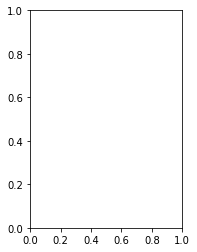

In [44]:
ax = plt.subplot(1,2,1)

In [45]:
ax.set_title("validation data")

Text(0.5,1,'validation data')

In [46]:
ax.set_autoscaley_on(False)

In [48]:
ax.set_ylim([32, 43])

(32, 43)

In [49]:
ax.set_autoscalex_on(False)

In [51]:
help(ax)

Help on AxesSubplot in module matplotlib.axes._subplots object:

class AxesSubplot(SubplotBase, matplotlib.axes._axes.Axes)
 |  Base class for subplots, which are :class:`Axes` instances with
 |  additional methods to facilitate generating and manipulating a set
 |  of :class:`Axes` within a figure.
 |  
 |  Method resolution order:
 |      AxesSubplot
 |      SubplotBase
 |      matplotlib.axes._axes.Axes
 |      matplotlib.axes._base._AxesBase
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods inherited from SubplotBase:
 |  
 |  __init__(self, fig, *args, **kwargs)
 |      *fig* is a :class:`matplotlib.figure.Figure` instance.
 |      
 |      *args* is the tuple (*numRows*, *numCols*, *plotNum*), where
 |      the array of subplots in the figure has dimensions *numRows*,
 |      *numCols*, and where *plotNum* is the number of the subplot
 |      being created.  *plotNum* starts at 1 in the upper left
 |      corner and increases to the right.
 |      
 |     

In [52]:
ax.set_xlim([-126, -112])

(-126, -112)

In [53]:
help(plt.scatter)

Help on function scatter in module matplotlib.pyplot:

scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None, hold=None, data=None, **kwargs)
    A scatter plot of *y* vs *x* with varying marker size and/or color.
    
    Parameters
    ----------
    x, y : array_like, shape (n, )
        The data positions.
    
    s : scalar or array_like, shape (n, ), optional
        The marker size in points**2.
        Default is ``rcParams['lines.markersize'] ** 2``.
    
    c : color, sequence, or sequence of color, optional, default: 'b'
        The marker color. Possible values:
    
        - A single color format string.
        - A sequence of color specifications of length n.
        - A sequence of n numbers to be mapped to colors using *cmap* and
          *norm*.
        - A 2-D array in which the rows are RGB or RGBA.
    
        Note that *c* should not be a single numeric RGB or RGBA seque

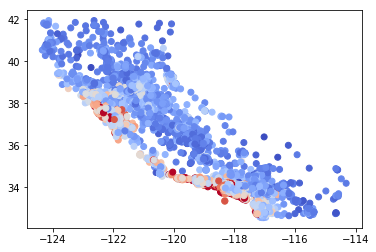

In [54]:
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())

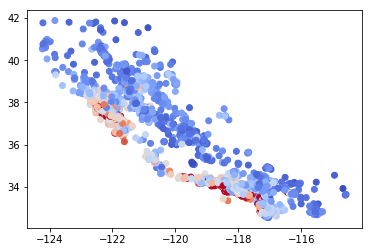

In [55]:
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

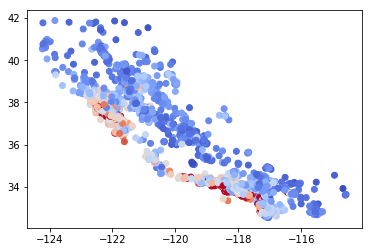

In [56]:
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

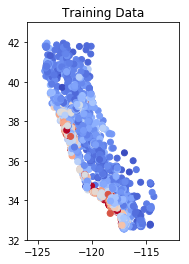

In [57]:
ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())

In [58]:
training_targets["median_house_value"].describe()

count   12000.0
mean      207.7
std       116.4
min        15.0
25%       119.6
50%       180.4
75%       265.6
max       500.0
Name: median_house_value, dtype: float64

In [59]:
training_targets["median_house_value"].describe()

count   12000.0
mean      207.7
std       116.4
min        15.0
25%       119.6
50%       180.4
75%       265.6
max       500.0
Name: median_house_value, dtype: float64

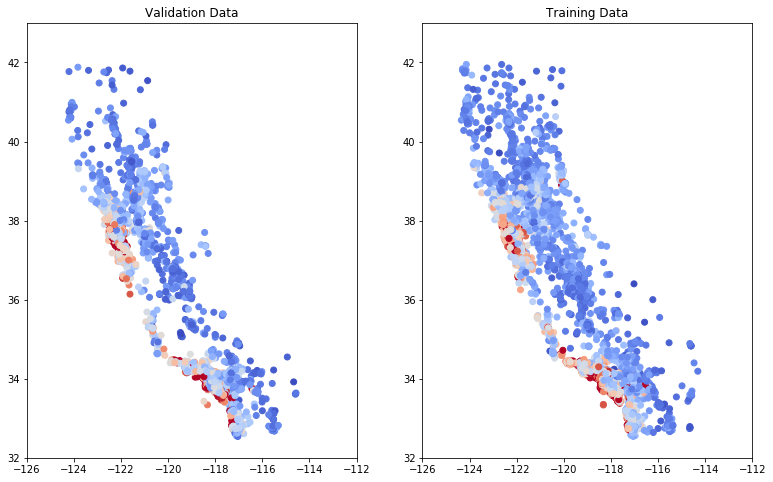

In [60]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())
_ = plt.plot()

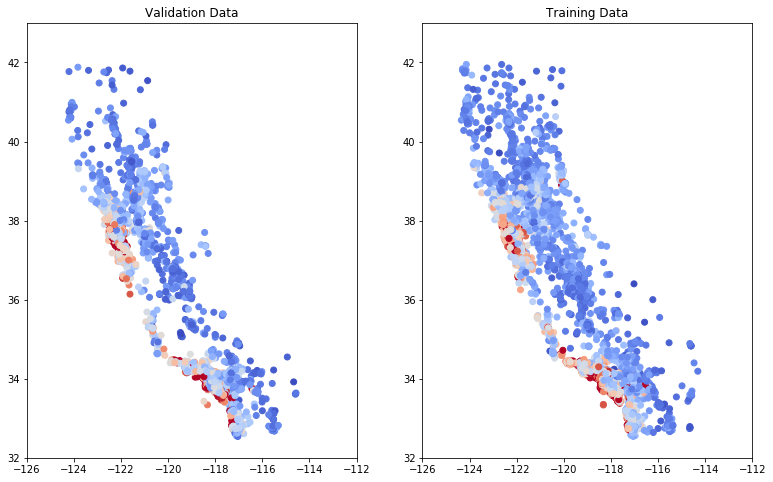

In [61]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())
_ = plt.plot()

In [62]:
training_examples.describe()
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2650.8,538.7,1436.5,500.5,3.9,2.0
std,2.1,2.0,12.5,2222.3,428.4,1205.3,388.3,1.9,1.0
min,32.5,-124.2,1.0,12.0,3.0,13.0,4.0,0.5,0.0
25%,33.9,-121.8,18.0,1457.0,294.0,785.8,279.0,2.6,1.5
50%,34.3,-118.5,29.0,2124.5,433.0,1174.5,409.0,3.6,1.9
75%,37.7,-118.0,37.0,3166.0,640.0,1732.2,604.0,4.8,2.3
max,41.9,-114.6,52.0,32054.0,5290.0,35682.0,5050.0,15.0,34.2


In [63]:
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2640.7,539.7,1426.7,501.5,3.9,2.0
std,2.1,2.0,12.6,2162.1,418.6,1123.1,382.9,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1464.0,298.0,791.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2129.0,434.0,1163.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3144.2,652.0,1717.2,606.0,4.7,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,55.2


In [64]:
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2650.8,538.7,1436.5,500.5,3.9,2.0
std,2.1,2.0,12.5,2222.3,428.4,1205.3,388.3,1.9,1.0
min,32.5,-124.2,1.0,12.0,3.0,13.0,4.0,0.5,0.0
25%,33.9,-121.8,18.0,1457.0,294.0,785.8,279.0,2.6,1.5
50%,34.3,-118.5,29.0,2124.5,433.0,1174.5,409.0,3.6,1.9
75%,37.7,-118.0,37.0,3166.0,640.0,1732.2,604.0,4.8,2.3
max,41.9,-114.6,52.0,32054.0,5290.0,35682.0,5050.0,15.0,34.2


[]

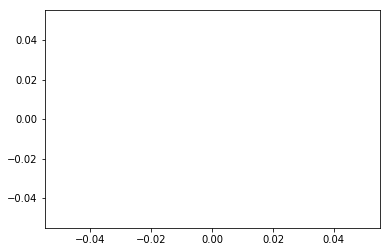

In [65]:
plt.plot()

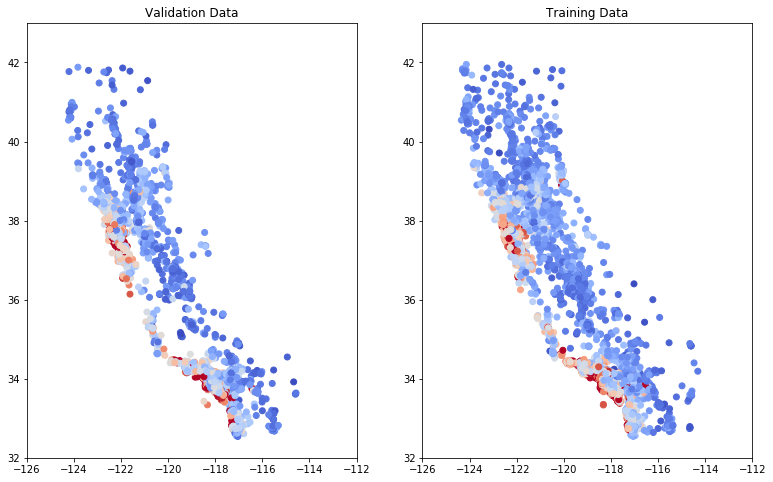

In [66]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())
_ = plt.plot()

In [67]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [68]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [69]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # 1. Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"],
      batch_size=batch_size)

  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"],
      batch_size=batch_size,
      shuffle=False,
      num_epochs=1)
    
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples,
      validation_targets["median_house_value"],
      num_epochs=1,
      shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )

    # 2. Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item["predictions"][0] for item in training_predictions])

    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print(" period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
 period 00 : 218.01
 period 01 : 200.26
 period 02 : 186.38
 period 03 : 176.21
 period 04 : 169.21
 period 05 : 167.09
 period 06 : 166.31
 period 07 : 167.11
 period 08 : 167.70
 period 09 : 167.96
Model training finished.


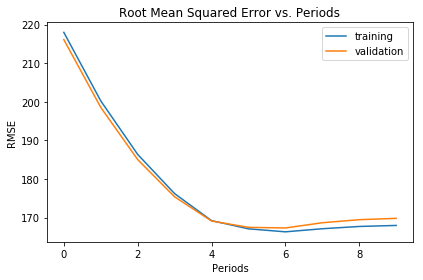

In [72]:
linear_regressor = train_model(
    learning_rate=0.00003,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [71]:
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2640.7,539.7,1426.7,501.5,3.9,2.0
std,2.1,2.0,12.6,2162.1,418.6,1123.1,382.9,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1464.0,298.0,791.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2129.0,434.0,1163.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3144.2,652.0,1717.2,606.0,4.7,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,55.2


Training model...
RMSE (on training data):
 period 00 : 218.03
 period 01 : 200.26
 period 02 : 186.53
 period 03 : 176.71
 period 04 : 170.60
 period 05 : 167.36
 period 06 : 166.29
 period 07 : 166.49
 period 08 : 167.50
 period 09 : 168.77
Model training finished.


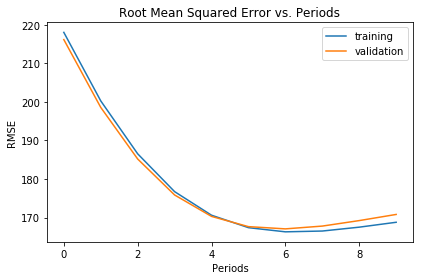

In [74]:
linear_regressor = train_model(
    learning_rate=0.00003,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
 period 00 : 218.02
 period 01 : 200.80
 period 02 : 185.91
 period 03 : 175.85
 period 04 : 170.47
 period 05 : 167.11
 period 06 : 166.26
 period 07 : 166.30
 period 08 : 167.05
 period 09 : 167.69
Model training finished.


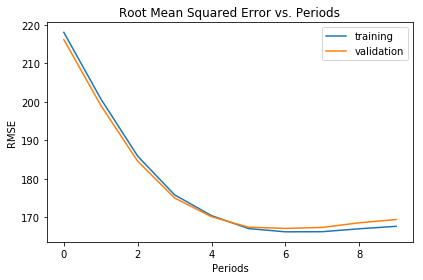

In [76]:
housing_data = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_test.csv", sep=",")

In [78]:
test_examples = preprocess_features(housing_data)

In [81]:
test_targets = preprocess_targets(housing_data)

In [98]:
predict_test_input_fn = lambda: my_input_fn(
    test_examples,
    test_targets["median_house_value"],
    num_epochs=1,
    shuffle=False)

In [101]:
test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)

In [104]:
test_predictions = np.array([ item["predictions"][0] for item in test_predictions])

In [107]:
rmse = math.sqrt(metrics.mean_squared_error(test_predictions, test_targets))

In [108]:
rmse

162.6558641976131